In [41]:
import ROOT
from ipywidgets import interact, IntSlider, IntText
from itertools import takewhile, count

f = ROOT.TFile('./filterWheel_GainCalibration/output_change4.root')#('../STDP/FW9.root')
module_label = 'islandFits'

if not ROOT.gROOT.FindObject('canv'):
    c = ROOT.TCanvas('canv', 'canv', 1000, 600)
if not ROOT.gROOT.FindObject('splitcanv'):
    split_c = ROOT.TCanvas('splitcanv', 'splitcanv', 1200, 800)
    split_c.Divide(9, 6, 0, 0)
bgen = takewhile(lambda s: isinstance(s, ROOT.TSpline3), 
                         (f.Get('{0}/splines/beam{1}'.format(module_label, i)) 
                          for i in count()))
bsplines = list(bgen)

lgen = takewhile(lambda s: isinstance(s, ROOT.TSpline3), 
                        (f.Get('{0}/splines/laser{1}'.format(module_label, i)) 
                         for i in count()))
lsplines = list(lgen)

t = f.Get('{}/fits/fitTree'.format(module_label))

subrun = 5
n_entries = t.BuildIndex('fillNum*(subRunNum=={})'.format(subrun),
                         'islandNums[0]*(xtalNum == 0 && subRunNum == {}) - 1*(xtalNum!=0)'.format(subrun))

# need global handle to currently plotted objects so that they don't get garbage collected
plotted_objects = None

In [42]:
# define plotting functions
def plot_fit(entry_num, canvas, single=True, grid_index=0, txt_coords=None):
    t.GetEntry(entry_num)
    calo_num = '?'
    try:
        calo_num = t.caloNum
    except AttributeError:
        pass
    # build graph
    sample_g = ROOT.TGraph(0)
    sample_g.SetName('g{}'.format(grid_index))
    if single:
        if len(t.islandNums) == 1:
            sample_g.SetTitle('run {0}, subrun {4}, fill {2}, island {3}, calo {5}, xtal {1}; sample num; adc counts'.
                              format(t.runNum, t.xtalNum, t.fillNum, t.islandNums[0], t.subRunNum, calo_num))
        else:
            sample_g.SetTitle('run {0}, subrun {4}, fill {2}, islands{3}, calo {5}, xtal {1}; sample num; adc counts'.
                              format(t.runNum, t.xtalNum, t.fillNum, 
                                     ''.join(' ' + str(num) for num in t.islandNums), t.subRunNum, calo_num))
    sample_g.SetMarkerStyle(20)
    if single:
        sample_g.SetMarkerSize(0.5)
    sample_g.SetMarkerColor(ROOT.kBlack)
    sample_times = sum((list(range(first, first+length)) for first, length in zip(t.firstSampleNums, t.islandLengths)),
                       [])

    for sample_time, samp in zip(sample_times, t.trace):
        sample_g.SetPoint(sample_g.GetN(), sample_time, samp)
    
    # build fit function
    try:
        bspline = bsplines[t.xtalNum]
        lspline = lsplines[t.xtalNum]
    except IndexError:
        print('no spline found for segment {}!'.format(t.xtalNum))
        return
    
    # need to copy parameters or closure doesn't work as intended
    energies = [e for e in t.energies]
    times = [float(t0) for t0 in t.times]
    ped = float(t.pedestal)
    laserhits = [bool(laserHit) for laserHit in t.laserHits]
    
    # draw graph and fit 
    sample_g.Draw("ap")
    x_min, x_max = (t.firstSampleNums[0], t.firstSampleNums[-1] + t.islandLengths[-1])
    y_min, y_max = (sample_g.GetYaxis().GetXmin(), sample_g.GetYaxis().GetXmax())
    sample_g.GetXaxis().SetLimits(x_min, x_max)
    
    # draw each single fit if multipulse fit
    def single_fit(x, p):
            is_laser = p[0]
            energy = p[1]
            t0 = p[2]
            spline = lspline if (is_laser) else bspline

            val = ped
            if spline.GetXmin() < (x[0]-t0) < spline.GetXmax():
                val += energy*spline.Eval(x[0]-t0)
            return val
        
    singleFits = []
    if len(times) >= 2:
        for i, (is_laser, energy, t0) in enumerate(zip(laserhits, energies, times)):            
            singleFits.append(ROOT.TF1('singleFitAt{}'.format(t0), single_fit, 
                                       x_min, x_max, 3))
            singleFits[-1].SetParameters(is_laser, energy, t0)            
            color = ROOT.kRed if i != 0 else ROOT.kBlue
            singleFits[-1].SetLineColor(color)
            singleFits[-1].SetNpx(10000)
            singleFits[-1].Draw("same")
    
    def fit_func(x):
        val = ped
        for (is_laser, energy, t0) in zip(laserhits, energies, times):
            spline = lspline if is_laser else bspline
            if spline.GetXmin() < (x[0]-t0) < spline.GetXmax():
                val += energy*spline.Eval(x[0]-t0)
        return val
    
    if not single:
        # scale based on ADC range for grid plot
        sample_g.GetYaxis().SetRangeUser(-2047, 2048)
        # range useful for early times looking at mips
        #sample_g.GetYaxis().SetRangeUser(-1850,-1640)
    fitTF1 = ROOT.TF1('fitfunc{}'.format(grid_index), fit_func, x_min, x_max, 0)
    fitTF1.SetNpx(10000)
    fitTF1.SetLineColor(ROOT.kMagenta + 2)
    # don't draw failed fits
    if t.chi2 > 0:
        fitTF1.Draw("same")
    
    if not single:
        sample_g.GetXaxis().SetLabelOffset(999)
        sample_g.GetYaxis().SetLabelOffset(999)
        return (sample_g, fitTF1, singleFits)

    # make text box
    txtbox = None
    if txt_coords is not None:
        x_range, y_range = (x_max - x_min, y_max - y_min)
        txt_pos = list(txt_coords)
        for i in [0,2]:
            txt_pos[i] = x_min + txt_pos[i]*x_range
        for i in [1, 3]:
            txt_pos[i] = y_min + txt_pos[i]*y_range

        txtbox = ROOT.TPaveText(*txt_pos)

        txtbox.SetFillColor(ROOT.kWhite)
        txtbox.SetLineColor(ROOT.kWhite)
        txtbox.SetShadowColor(ROOT.kWhite)
        for (i, (is_laser, energy, t0, s)) in enumerate(zip(t.laserHits, t.energies, t.times, t.statuses)):
            if (is_laser):
                txtbox.AddText('laser')
            else:
                txtbox.AddText('beam')
            txtbox.AddText('t_{{{0}}}: {1:0.3f}'.format(i, t0))
            txtbox.AddText('E_{{{0}}}: {1:0.1f}'.format(i, energy))
            txtbox.AddText('status_{{{0}}}: {1:1.0f}'.format(i, s))
        txtbox.AddText('pedestal: {:0.1f}'.format(t.pedestal))
        txtbox.AddText('#chi^{{2}}: {:0.1f}'.format(t.chi2))
        txtbox.Draw()
    
    sample_g.GetYaxis().SetTitleOffset(2)
    sample_g.GetXaxis().SetRangeUser(x_min,x_max)
    canvas.Draw()
    return (sample_g, fitTF1, txtbox, singleFits)

def plot_one_with_index(fill_num, island_num, xtal_num, txt_coords=(0.5, 0.9, 0.9, 0.3)):
    ROOT.gStyle.SetOptTitle(1)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1:
        c.cd()
        global plotted_objects
        plotted_objects = plot_fit(entry_num + xtal_num, c, txt_coords=txt_coords)
    else:
        print('entry not found in index')

def plot_grid_with_index(fill_num, island_num):
    ROOT.gStyle.SetOptTitle(0)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1:
        # have to make sure objects are not garbage collected
        objects = []
        for xtal_num in range(54): 
            split_c.cd(54 - xtal_num)
            objects.append(plot_fit(entry_num, split_c, single=False, grid_index=xtal_num))
            entry_num += 1
        split_c.Draw()
        global plotted_objects
        plotted_objects = objects
        print('first sample is at {} ns'.format(t.firstSampleNums[0]*1.25))
    else:
        print('entry not found in index')

In [43]:
counter = 0
#coinTimes = ROOT.TH2D("coinTimes","coinTimes",100,0.0,10.0,100,0.0,10.0)
for e in t:
    """if e.times.size() > 2:
        timesArr = []
        for j in range(0,e.times.size()):
            timesArr.append(e.times[j])
        timesArr.sort()
        for k in range(2, len(timesArr)):
            coinTimes.Fill(timesArr[k-1] - timesArr[k-2],timesArr[k] - timesArr[k-1])"""
    #for k in e.statuses: 
        #if k == 1:
    if( counter < 150): #and e.times[0]*1.25/1000 < 100
        print(t.fillNum)
        #print(k)
        print(t.islandNums[0])
        print(t.xtalNum)
        #print(min(t.trace))
        #print(t.pedestal)
        p = 0
        for j in e.times:
            print(j)
        print()
        counter += 1

2
1
0
5565.1227860248655

2
1
1
5564.7210748032285

2
1
2
5565.836991576796

2
1
3
5567.084499051731

2
1
4
5565.564428273981

2
1
5
5565.847861687072

2
1
6
5566.956781327068

2
1
7
5565.764378992316

2
1
8
5565.312528889291

2
1
9
5566.458213396451

2
1
10
5565.078754133372

2
1
11
5566.118434085209

2
1
12
5566.504601328125

2
1
13
5566.134103060605

2
1
14
5567.36831850214

2
1
15
5566.43860109829

2
1
16
5567.181124970285

2
1
17
5565.703161703175

2
1
18
5565.518711776147

2
1
19
5565.139348211811

2
1
20
5565.224266356765

2
1
21
5566.5910979917335

2
1
22
5566.008977857896

2
1
23
5566.312622431606

2
1
24
5566.393510832372

2
1
25
5566.21199080274

2
1
26
5564.741841674952

2
1
27
5565.144291989911

2
1
28
5565.728451549409

2
1
29
5564.72229431388

2
1
30
5566.0947252101205

2
1
31
5565.5205052466845

2
1
32
5566.956279118483

2
1
33
5565.990239549579

2
1
34
5566.7624353999145

2
1
35
5566.31983602245

2
1
36
5566.872420445359

2
1
37
5566.0

2
1
38
5565.568119513699

2
1
39

In [44]:
plot_one_with_index(2,0,37) #calo 9

entry not found in index


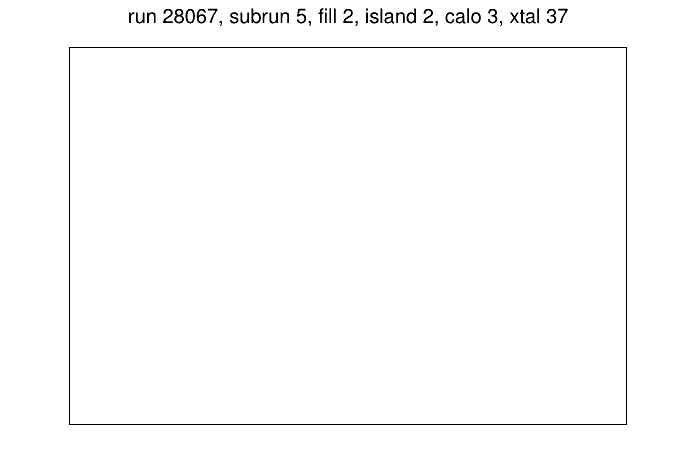

In [36]:
canvases[2].Draw()

## plot_one_with_index(22,93,2)

first sample is at 6942.5 ns


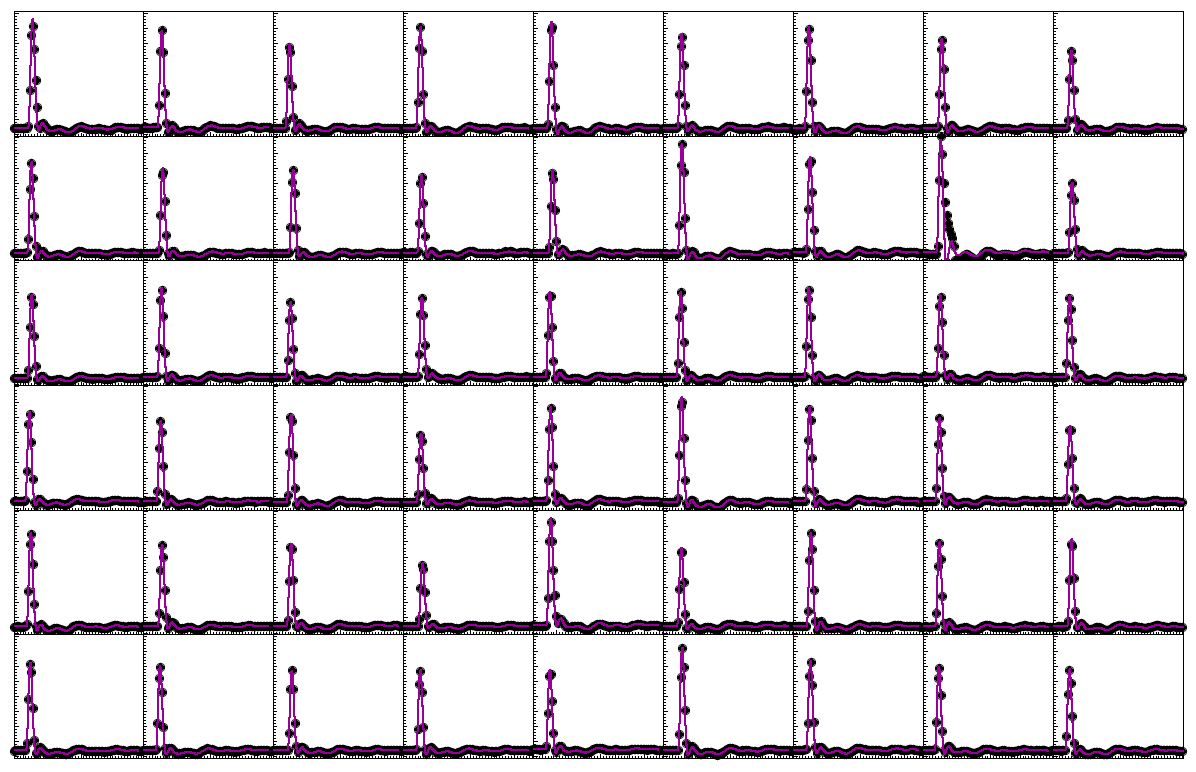

In [23]:
plot_grid_with_index(2,1) #calo 9 